In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load original dataset
df = pd.read_csv("dataset_con_texto.csv")

# Check initial shape
print("✅ Dataset loaded:", df.shape)


✅ Dataset loaded: (6926, 84)


In [2]:
# Use the column 'variable' to create the target directly (Control, Ansiedad, Depresion)
df["target"] = df["variable"].str.strip()

# Show value counts to confirm balance
print(df["target"].value_counts())



target
Control      2433
Depresion    2260
Ansiedad     2233
Name: count, dtype: int64


In [3]:
# Save text columns for later
text_cols = df[["text", "translation"]].copy()

# Drop non-useful columns
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Drop column with mostly missing values
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True, errors='ignore')

# Fill remaining nulls
for col in df.columns[df.isnull().any()]:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Drop text columns for now
df = df.drop(columns=["text", "translation"], errors="ignore")

print("✅ Cleaning complete. Shape:", df.shape)


✅ Cleaning complete. Shape: (6926, 67)


In [4]:
# Separate X (features) and y (target)
X = df.drop(columns="target")
y = df["target"]

# Check class balance before splitting
print("📌 Class distribution before split:")
print(y.value_counts())

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

print(f"✅ Shapes: X_train={X_train.shape}, X_test={X_test.shape}")


📌 Class distribution before split:
target
Control      2433
Depresion    2260
Ansiedad     2233
Name: count, dtype: int64
✅ Shapes: X_train=(4848, 66), X_test=(2078, 66)


In [6]:
# Only select numeric columns for scaling
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Fit a multiclass logistic regression model using One-vs-Rest
model = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr'))
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


In [11]:
from sklearn.preprocessing import LabelEncoder

# Use original multiclass labels
y = df["target"]  # This contains "Control", "Ansiedad", "Depresion"

# Encode the target into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Show label mapping
print("🔢 Etiquetas codificadas:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))



🔢 Etiquetas codificadas: {'Ansiedad': 0, 'Control': 1, 'Depresion': 2}


In [12]:
# Eliminar columnas categóricas y texto (ya guardadas antes como text_cols)
categorical_and_text = [
    'most_frequent_dominant_emotion',
    'voice_mean_note', 'voice_median_note', 'voice_mode_note',
    'voice_Q25_note', 'voice_Q75_note',
    'language', 'text', 'translation'
]

X_clean = X.drop(columns=categorical_and_text, errors='ignore')

# Confirm dimensions
print("✅ Dimensiones finales de X_clean:", X_clean.shape)


✅ Dimensiones finales de X_clean: (6926, 59)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split with stratification to preserve label balance
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos escalados correctamente")


✅ Datos escalados correctamente


In [14]:
from sklearn.linear_model import LogisticRegression

# Multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)


 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.51      0.44      0.47       670
     Control       0.72      0.82      0.77       730
   Depresion       0.48      0.47      0.47       678

    accuracy                           0.58      2078
   macro avg       0.57      0.58      0.57      2078
weighted avg       0.57      0.58      0.58      2078



<Figure size 432x360 with 0 Axes>

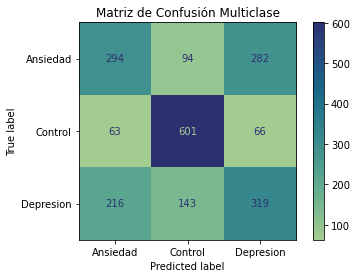

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Classification report
print(" Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap="crest")  # 🎨 new palette, different from magma/viridis/rocket
plt.title("Matriz de Confusión Multiclase")
plt.grid(False)
plt.show()


# Only Text

📋 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.74      0.73      0.74       670
     Control       0.83      0.89      0.86       730
   Depresion       0.73      0.69      0.71       678

    accuracy                           0.77      2078
   macro avg       0.77      0.77      0.77      2078
weighted avg       0.77      0.77      0.77      2078



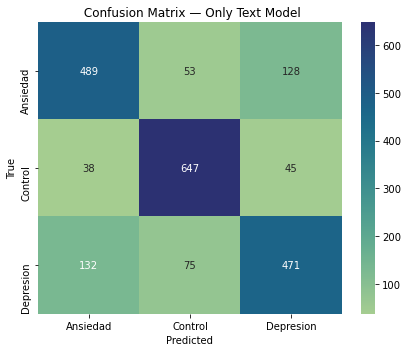

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Asegurar que la columna 'translation' esté presente
if "translation" not in X.columns:
    X["translation"] = text_cols["translation"]

# 🔹 Vectorización TF-IDF sobre 'translation'
tfidf = TfidfVectorizer(max_features=300)
X_text = tfidf.fit_transform(X["translation"].fillna("")).toarray()

# 🔹 Codificar etiquetas (Control, Ansiedad, Depresion)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 🔹 Dividir en entrenamiento y test
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# 🔹 Entrenar modelo
model_text = LogisticRegression(max_iter=1000)
model_text.fit(X_train_text, y_train_text)

# 🔹 Predecir
y_pred_text = model_text.predict(X_test_text)

# 🔹 Informe de clasificación
print("📋 Classification Report:\n")
print(classification_report(y_test_text, y_pred_text, target_names=label_encoder.classes_))

# 🔹 Matriz de confusión
conf_mat = confusion_matrix(y_test_text, y_pred_text)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="crest",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(" Confusion Matrix — Only Text Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


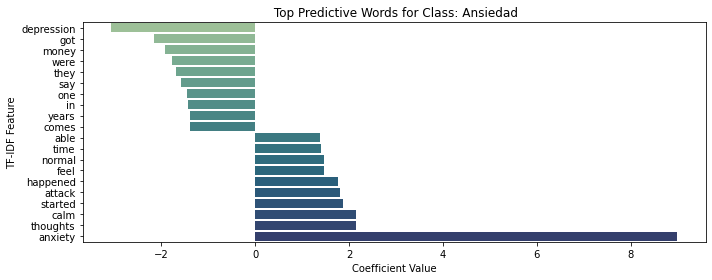

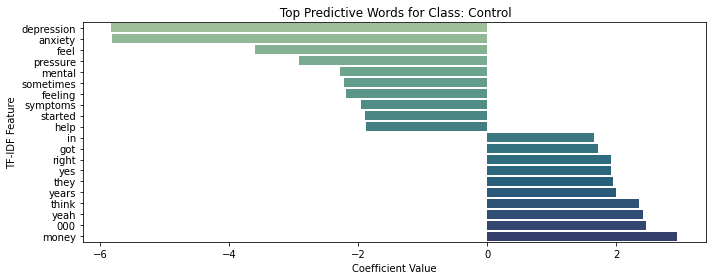

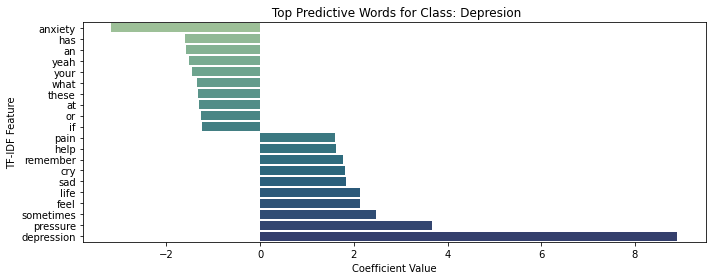

In [28]:
import numpy as np
import pandas as pd

# Obtener los coeficientes por clase
coefs = model_text.coef_
feature_names = tfidf.get_feature_names_out()

# Para cada clase, mostramos las 10 palabras más representativas
for idx, class_name in enumerate(label_encoder.classes_):
    top_idx = np.argsort(coefs[idx])[-10:]  # top 10 positivas
    bottom_idx = np.argsort(coefs[idx])[:10]  # top 10 negativas
    plt.figure(figsize=(10, 4))
    sns.barplot(
        x=np.concatenate((coefs[idx][bottom_idx], coefs[idx][top_idx])),
        y=np.concatenate((feature_names[bottom_idx], feature_names[top_idx])),
        palette="crest"
    )
    plt.title(f" Top Predictive Words for Class: {class_name}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("TF-IDF Feature")
    plt.tight_layout()
    plt.show()


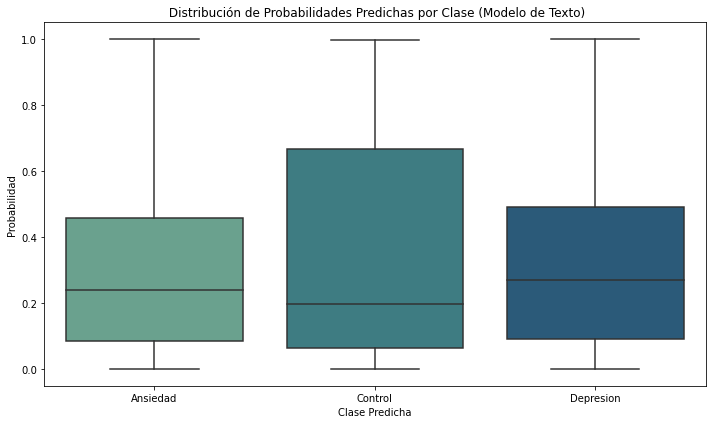

In [30]:
# Transformar de wide a long format para Seaborn
df_probs_long = df_probs.melt(var_name="Clase", value_name="Probabilidad")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Clase", y="Probabilidad", data=df_probs_long, palette="crest")
plt.title(" Distribución de Probabilidades Predichas por Clase (Modelo de Texto)")
plt.xlabel("Clase Predicha")
plt.ylabel("Probabilidad")
plt.tight_layout()
plt.show()



<Figure size 720x432 with 0 Axes>

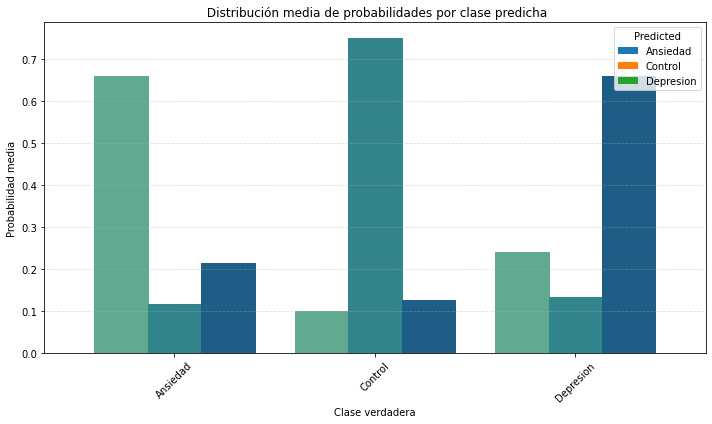

In [34]:
# Agrupamos por clase predicha
mean_probs = df_probs.groupby("Predicted").mean()

# Plot manual con seaborn para evitar errores con colormaps
plt.figure(figsize=(10, 6))
mean_probs.T.plot(kind="bar", figsize=(10, 6), width=0.8)

# Aplicamos colores de la paleta "crest"
colors = sns.color_palette("crest", n_colors=mean_probs.shape[0])
for i, bar_group in enumerate(plt.gca().containers):
    for bar in bar_group:
        bar.set_color(colors[i])

plt.title(" Distribución media de probabilidades por clase predicha")
plt.ylabel("Probabilidad media")
plt.xlabel("Clase verdadera")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



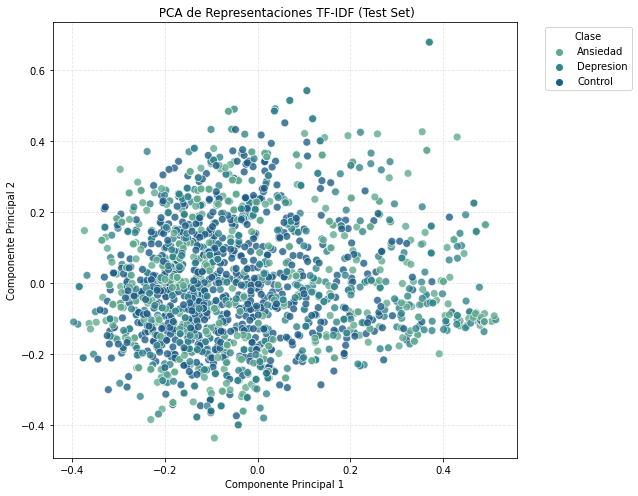

In [37]:
from sklearn.decomposition import PCA

# PCA en lugar de t-SNE para mayor compatibilidad y estabilidad
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_text)

# Crear DataFrame con resultados
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Clase Verdadera"] = label_encoder.inverse_transform(y_test_text)

# Visualización
plt.figure(figsize=(9, 7))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Clase Verdadera", palette="crest", s=60, alpha=0.8)
plt.title(" PCA de Representaciones TF-IDF (Test Set)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [42]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 🔹 Detect categorical and numerical columns
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 🔹 Column transformer: OHE para categóricas, Escalar para numéricas
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# 🔹 Fit-transform sobre todo X tabular
X_tabular_transformed = preprocessor.fit_transform(X)

# 🔹 Concatenar con TF-IDF de 'translation'
from scipy.sparse import hstack
X_hybrid = hstack([X_text, X_tabular_transformed])  # Todo ya está numérico

# 🔹 Split híbrido
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_hybrid, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

print(f"✅ Datos híbridos listos: X_train_h={X_train_h.shape}, X_test_h={X_test_h.shape}")


✅ Datos híbridos listos: X_train_h=(4848, 3988), X_test_h=(2078, 3988)


Classification Report (Modelo Híbrido):

              precision    recall  f1-score   support

    Ansiedad       0.87      0.84      0.85       670
     Control       0.93      0.94      0.94       730
   Depresion       0.84      0.86      0.85       678

    accuracy                           0.88      2078
   macro avg       0.88      0.88      0.88      2078
weighted avg       0.88      0.88      0.88      2078



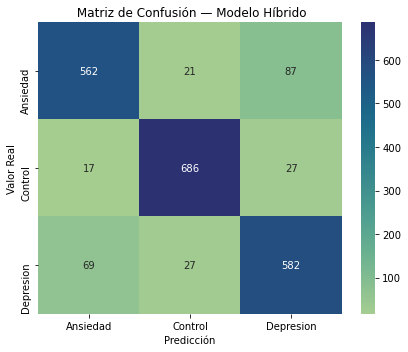

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Entrenamiento del modelo híbrido
model_hybrid = LogisticRegression(max_iter=1000)
model_hybrid.fit(X_train_h, y_train_h)

# 🔹 Predicción
y_pred_h = model_hybrid.predict(X_test_h)

# 🔹 Reporte de clasificación
print("Classification Report (Modelo Híbrido):\n")
print(classification_report(y_test_h, y_pred_h, target_names=label_encoder.classes_))

# 🔹 Matriz de confusión
conf_matrix_h = confusion_matrix(y_test_h, y_pred_h)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_h, annot=True, fmt="d", cmap="crest",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(" Matriz de Confusión — Modelo Híbrido")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()


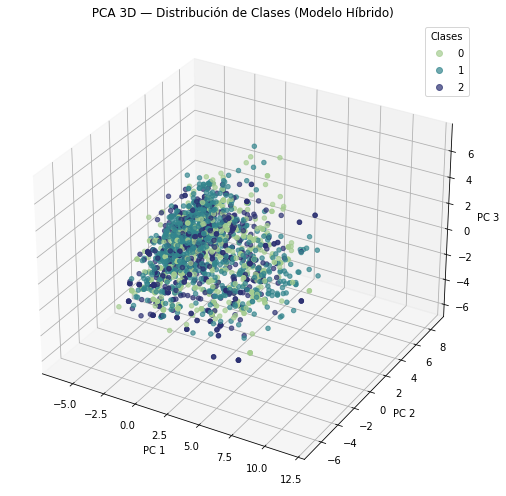

In [49]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA a 3 componentes para visualizar la nube de puntos híbrida
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_test_h.toarray() if hasattr(X_test_h, "toarray") else X_test_h)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], 
                     c=y_test_h, cmap="crest", alpha=0.7)
legend = ax.legend(*scatter.legend_elements(), title="Clases", loc="best")
ax.set_title(" PCA 3D — Distribución de Clases (Modelo Híbrido)")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.tight_layout()
plt.show()



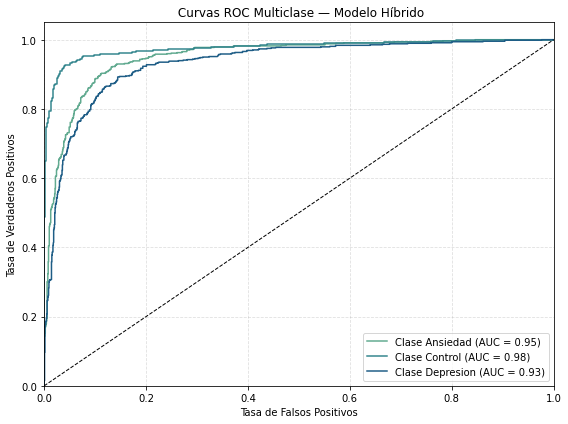

In [54]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from itertools import cycle

# 🔹 Binarizar las etiquetas
y_test_bin = label_binarize(y_test_h, classes=[0, 1, 2])  # asumiendo 3 clases
n_classes = y_test_bin.shape[1]

# 🔹 Ajustar modelo con estrategia One-vs-Rest
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
classifier.fit(X_train_h, label_binarize(y_train_h, classes=[0, 1, 2]))
y_score = classifier.predict_proba(X_test_h)

# 🔹 Calcular fpr, tpr, auc para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 🔹 Colores y estilos
colors = cycle(sns.color_palette("crest", n_colors=n_classes))

# 🔹 Plot
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Clase {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title(" Curvas ROC Multiclase — Modelo Híbrido")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


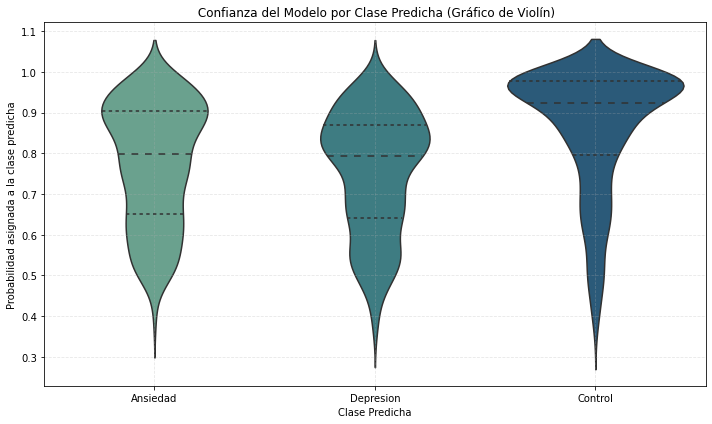

In [57]:
# Probabilidades predichas
probs_h = model_hybrid.predict_proba(X_test_h)
y_pred_labels = label_encoder.inverse_transform(y_pred_h)

# DataFrame para graficar
df_violin = pd.DataFrame(probs_h, columns=label_encoder.classes_)
df_violin['Clase Predicha'] = y_pred_labels

# Derivar la confianza (máxima probabilidad por muestra)
df_violin['Confianza'] = df_violin[label_encoder.classes_].max(axis=1)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_violin, x='Clase Predicha', y='Confianza', palette='crest', inner='quartile')
plt.title(" Confianza del Modelo por Clase Predicha (Gráfico de Violín)")
plt.ylabel("Probabilidad asignada a la clase predicha")
plt.xlabel("Clase Predicha")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



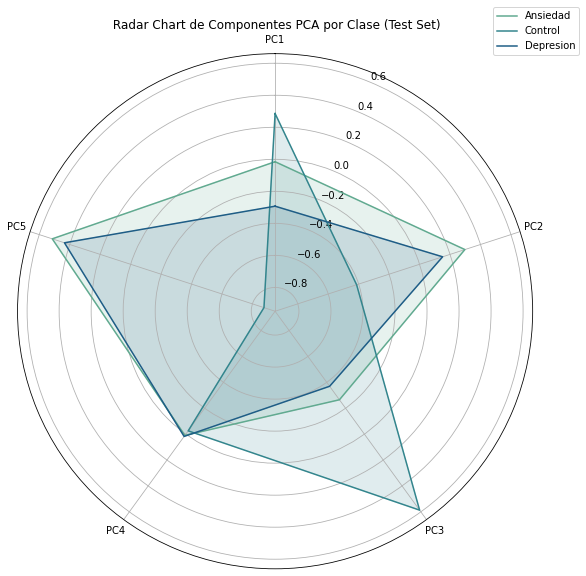

In [62]:
from math import pi
from sklearn.decomposition import PCA

# Reducción de dimensionalidad para poder representar en radar
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_test_h.toarray())

df_radar = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(5)])
df_radar['Clase'] = label_encoder.inverse_transform(y_test_h)

# Promedio por clase
df_radar_avg = df_radar.groupby("Clase").mean()

# Radar requiere formato circular
labels = df_radar_avg.columns
num_vars = len(labels)

# Ángulos de cada eje
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Crear figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Paleta crest
colors = sns.color_palette("crest", n_colors=len(df_radar_avg))

# Dibujar una línea por clase
for (idx, row), color in zip(df_radar_avg.iterrows(), colors):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=idx, color=color)
    ax.fill(angles, values, color=color, alpha=0.15)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids([a * 180/pi for a in angles[:-1]], labels)
plt.title(" Radar Chart de Componentes PCA por Clase (Test Set)")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


# SUBGROUPS

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure no NaNs remain in text
text_cols["translation"] = text_cols["translation"].fillna("")

# Create TF-IDF features (limit vocab for interpretability)
tfidf = TfidfVectorizer(max_features=60, stop_words='english')
X_tfidf = tfidf.fit_transform(text_cols["translation"]).toarray()
tfidf_cols = [f"tfidf_{word}" for word in tfidf.get_feature_names_out()]
df_tfidf = pd.DataFrame(X_tfidf, columns=tfidf_cols, index=X.index)

# Merge with original X
X_text_augmented = pd.concat([X.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)


In [67]:
subgroups = {}

# Facial & Emotion & Text
subgroups["facial_emotion_text"] = [
    col for col in X.columns if "face_" in col or "emotion" in col or "eye" in col
][:20] + tfidf_cols[:10]

# Voice & Acoustic Features & Text
subgroups["voice_acoustic_text"] = [
    col for col in X.columns if "voice_" in col or "pitch" in col or "arousal" in col or "valence" in col
][:20] + tfidf_cols[10:20]

# Movement & Distance & Biometric & Text
subgroups["movement_biometric_text"] = [
    col for col in X.columns if "movement" in col or "area" in col or "distance" in col or "frame" in col
][:20] + tfidf_cols[20:30]

# Sentiment features + Facial + Text
subgroups["sentiment_facial_text"] = [
    col for col in X.columns if "valence" in col or "arousal" in col or "emotion" in col or "eye" in col
][:20] + tfidf_cols[30:40]

# Full hybrid: all sensory + text
subgroups["hybrid_all_text"] = (
    subgroups["facial_emotion_text"][:10] +
    subgroups["voice_acoustic_text"][:10] +
    subgroups["movement_biometric_text"][:10] +
    tfidf_cols[40:50]
)

# Deep hybrid: movement + sentiment + voice + translation
subgroups["deep_mixed_text"] = (
    subgroups["movement_biometric_text"][:8] +
    subgroups["sentiment_facial_text"][:8] +
    subgroups["voice_acoustic_text"][:8] +
    tfidf_cols[50:60]
)

# Print summary of all subgroups
for name, features in subgroups.items():
    print(f"✅ Subgroup '{name}' contains {len(features)} features")


✅ Subgroup 'facial_emotion_text' contains 12 features
✅ Subgroup 'voice_acoustic_text' contains 26 features
✅ Subgroup 'movement_biometric_text' contains 10 features
✅ Subgroup 'sentiment_facial_text' contains 11 features
✅ Subgroup 'hybrid_all_text' contains 40 features
✅ Subgroup 'deep_mixed_text' contains 34 features


In [68]:
# Movement & Distance & Biometric & Text
subgroups["movement_biometric_text"] = [
    col for col in X.columns if "movement" in col or "distance" in col or "biometric" in col or "area" in col or "frame" in col
][:20] + tfidf_cols[20:30]

# Hybrid 1: Facial + Voice + Text
subgroups["hybrid_facial_voice_text"] = list(set(
    [col for col in X.columns if "face_" in col or "emotion" in col][:10] +
    [col for col in X.columns if "voice_" in col][:10] +
    tfidf_cols[30:45]
))

# Hybrid 2: Emotion + Biometric + Text
subgroups["hybrid_emotion_bio_text"] = list(set(
    [col for col in X.columns if "arousal" in col or "valence" in col or "emotion" in col][:10] +
    [col for col in X.columns if "biometric" in col or "distance" in col][:10] +
    tfidf_cols[15:30]
))

# Hybrid 3: Full-blend from all systems
subgroups["hybrid_full_text"] = list(set(
    [col for col in X.columns if "face" in col][:7] +
    [col for col in X.columns if "voice" in col][:7] +
    [col for col in X.columns if "movement" in col][:6] +
    tfidf_cols[45:60]
))

# Print summary of subgroup sizes
for name, cols in subgroups.items():
    print(f"✅ Subgroup '{name}' contains {len(cols)} features")


✅ Subgroup 'facial_emotion_text' contains 12 features
✅ Subgroup 'voice_acoustic_text' contains 26 features
✅ Subgroup 'movement_biometric_text' contains 10 features
✅ Subgroup 'sentiment_facial_text' contains 11 features
✅ Subgroup 'hybrid_all_text' contains 40 features
✅ Subgroup 'deep_mixed_text' contains 34 features
✅ Subgroup 'hybrid_facial_voice_text' contains 27 features
✅ Subgroup 'hybrid_emotion_bio_text' contains 16 features
✅ Subgroup 'hybrid_full_text' contains 23 features


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Re-add text
X["translation"] = text_cols["translation"]

# Create TF-IDF features from cleaned translation column
cleaned_translation = X["translation"].fillna("").astype(str)
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
X_tfidf_array = tfidf.fit_transform(cleaned_translation).toarray()
tfidf_cols = [f"tfidf_{word}" for word in tfidf.get_feature_names_out()]
df_tfidf = pd.DataFrame(X_tfidf_array, columns=tfidf_cols, index=X.index)

# Remove translation from X to avoid string columns
X_clean = X.drop(columns=["translation"], errors="ignore")

# Combine numeric X with TF-IDF
X_text_augmented = pd.concat([X_clean.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)

# Only use numeric features for subgrouping
numeric_cols = X_text_augmented.select_dtypes(include=["number"]).columns.tolist()

# Build subgroups with at least 20 variables
subgroups = {}

# 1. Facial + Emotion + Text
subgroups["facial_emotion_text"] = [
    col for col in numeric_cols if "face_" in col or "emotion" in col or "eye" in col
][:20] + tfidf_cols[:10]

# 2. Voice + Arousal/Valence + Text
subgroups["voice_emotion_text"] = [
    col for col in numeric_cols if "voice_" in col or "pitch" in col or "valence" in col or "arousal" in col
][:20] + tfidf_cols[10:20]

# 3. Movement + Distance + Text
subgroups["movement_biometrics_text"] = [
    col for col in numeric_cols if "movement" in col or "distance" in col or "area" in col or "frame" in col
][:20] + tfidf_cols[20:30]

# 4. Hybrid facial + voice + text
subgroups["hybrid_facial_voice_text"] = list(set(
    subgroups["facial_emotion_text"][:15] +
    subgroups["voice_emotion_text"][:15] +
    tfidf_cols[30:40]
))

# 5. Hybrid sentiment + biometric + text
subgroups["hybrid_sentiment_biometric_text"] = list(set(
    subgroups["movement_biometrics_text"][:15] +
    subgroups["voice_emotion_text"][:10] +
    tfidf_cols[40:50]
))

# 6. Fully balanced hybrid set
subgroups["hybrid_all_text"] = list(set(
    subgroups["facial_emotion_text"][:10] +
    subgroups["voice_emotion_text"][:10] +
    subgroups["movement_biometrics_text"][:10] +
    tfidf_cols[:20]
))

# Summary
for name, cols in subgroups.items():
    print(f"✅ Subgroup '{name}' has {len(cols)} features")


✅ Subgroup 'facial_emotion_text' has 11 features
✅ Subgroup 'voice_emotion_text' has 21 features
✅ Subgroup 'movement_biometrics_text' has 10 features
✅ Subgroup 'hybrid_facial_voice_text' has 36 features
✅ Subgroup 'hybrid_sentiment_biometric_text' has 30 features
✅ Subgroup 'hybrid_all_text' has 41 features


🔹 Classification Report — facial_emotion_text:

              precision    recall  f1-score   support

    Ansiedad       0.90      0.46      0.61       670
     Control       0.50      0.98      0.66       730
   Depresion       0.87      0.37      0.52       678

    accuracy                           0.61      2078
   macro avg       0.75      0.60      0.59      2078
weighted avg       0.75      0.61      0.60      2078



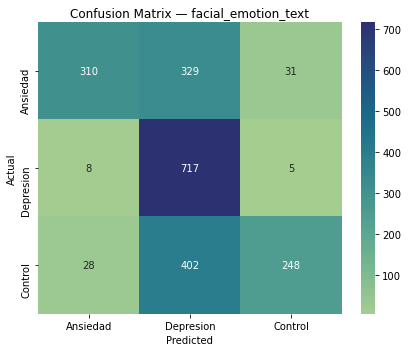

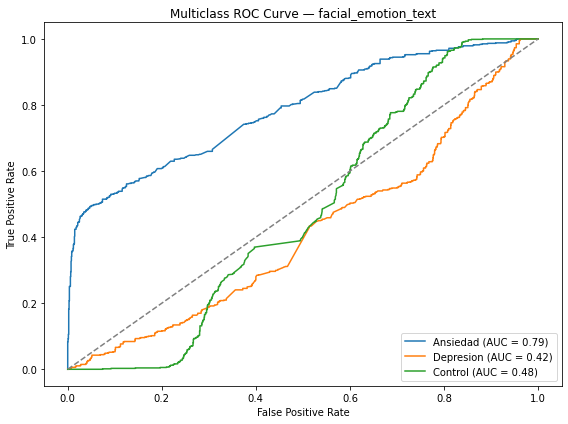

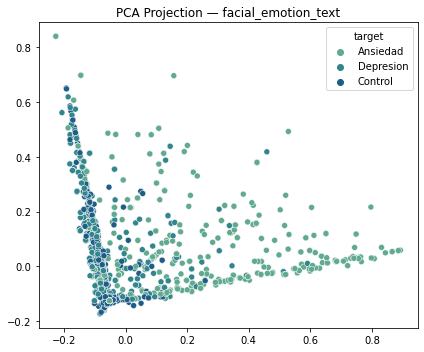

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
features = subgroups["facial_emotion_text"]
X_s = X_text_augmented[features]
y_s = y.copy()

# Binarize labels for multiclass ROC
class_names = y_s.unique()
y_bin = label_binarize(y_s, classes=class_names)

# Train/test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, stratify=y_s, test_size=0.3, random_state=42)
y_test_bin = label_binarize(y_test_s, classes=class_names)

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Report
print("🔹 Classification Report — facial_emotion_text:\n")
print(classification_report(y_test_s, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_s, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="crest",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — facial_emotion_text")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Multiclass ROC Curve
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve — facial_emotion_text")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection — facial_emotion_text")
plt.tight_layout()
plt.show()


In [74]:
# Check all column names in X_text_augmented
print("✅ Available features in X_text_augmented:\n")
print(X_text_augmented.columns.tolist())

# Check which features from the last subgroup are missing
missing_features = [col for col in hybrid_voice_text_emotion if col not in X_text_augmented.columns]
print("\n❌ Missing features in subgroup 'hybrid_voice_text_emotion':")
print(missing_features)


✅ Available features in X_text_augmented:

['angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial', 'sad_facial', 'surprise_facial', 'neutral_facial', 'most_frequent_dominant_emotion', 'average_face_confidence', 'extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness', 'survival', 'creativity', 'self_esteem', 'compassion', 'communication', 'imagination', 'awareness', 'stress_high', 'stress_medium', 'stress_low', 'helplessness_high', 'helplessness_medium', 'helplessness_low', 'self_efficacy_medium', 'self_efficacy_low', 'self_efficacy_high', 'depression_high', 'depression_medium', 'depression_low', 'voice_mean', 'voice_sd', 'voice_median', 'voice_mode', 'voice_Q25', 'voice_Q75', 'voice_IQR', 'voice_skewness', 'voice_kurtosis', 'voice_mean_note', 'voice_median_note', 'voice_mode_note', 'voice_Q25_note', 'voice_Q75_note', 'voice_rmse', 'pitch', 'tone', 'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice', 'happy_voice', 'angry_voice', 'calm_voice'

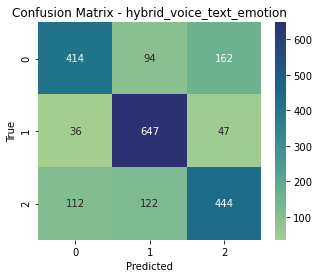

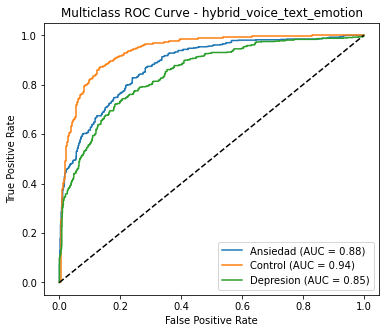

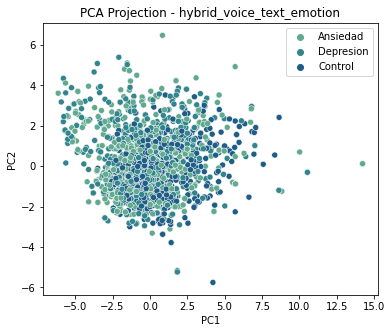

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.74      0.62      0.67       670
     Control       0.75      0.89      0.81       730
   Depresion       0.68      0.65      0.67       678

    accuracy                           0.72      2078
   macro avg       0.72      0.72      0.72      2078
weighted avg       0.72      0.72      0.72      2078



In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: voice + emotion + text (adjusted to valid columns)
hybrid_voice_text_emotion = [
    "voice_mean", "voice_sd", "voice_median", "voice_mode", "voice_Q25", "voice_Q75", "voice_IQR", 
    "voice_skewness", "voice_kurtosis", "voice_rmse", "pitch", "tone", "sad_voice", "happy_voice", 
    "angry_voice", "fearful_voice", "disgust_voice", "calm_voice", "no_speech_prob", "entropy",
    "tfidf_feel", "tfidf_life", "tfidf_depression", "tfidf_anxiety", "tfidf_help", "tfidf_bad", "tfidf_going"
]

# Select features and target
X_s = X_text_augmented[hybrid_voice_text_emotion]
y_s = y.copy()

# Standardize features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - hybrid_voice_text_emotion")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (One-vs-Rest)
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - hybrid_voice_text_emotion")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - hybrid_voice_text_emotion")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


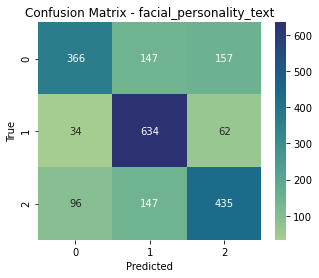

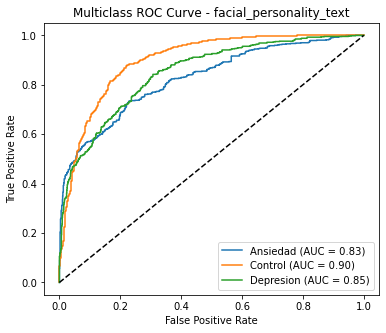

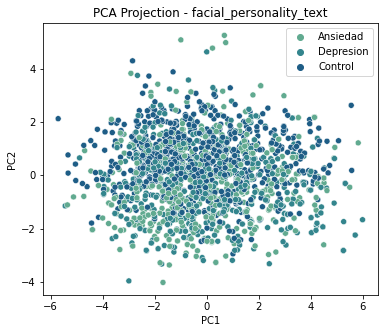

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.74      0.55      0.63       670
     Control       0.68      0.87      0.76       730
   Depresion       0.67      0.64      0.65       678

    accuracy                           0.69      2078
   macro avg       0.70      0.69      0.68      2078
weighted avg       0.69      0.69      0.68      2078



In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: facial + personality + text features
facial_personality_text = [
    "angry_facial", "disgust_facial", "fear_facial", "happy_facial", "sad_facial", "surprise_facial", 
    "neutral_facial", "average_face_confidence", 
    "extraversion", "neuroticism", "agreeableness", "conscientiousness", "openness",
    "self_esteem", "creativity", "awareness", "imagination", "compassion", "communication", "survival",
    "tfidf_feel", "tfidf_depression", "tfidf_anxiety", "tfidf_god", "tfidf_life", "tfidf_think", 
    "tfidf_people", "tfidf_time", "tfidf_love", "tfidf_work"
]

# Select features and target
X_s = X_text_augmented[facial_personality_text]
y_s = y.copy()

# Scale the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - facial_personality_text")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (Multiclass)
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - facial_personality_text")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - facial_personality_text")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


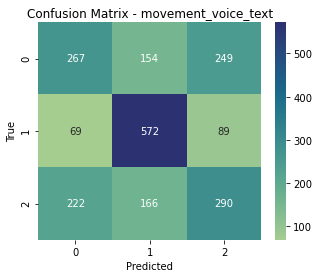

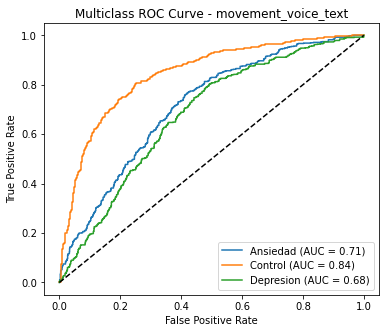

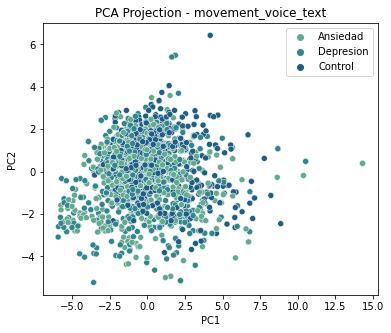

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.48      0.40      0.43       670
     Control       0.64      0.78      0.71       730
   Depresion       0.46      0.43      0.44       678

    accuracy                           0.54      2078
   macro avg       0.53      0.54      0.53      2078
weighted avg       0.53      0.54      0.53      2078



In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: movement + voice + text features
movement_voice_text = [
    "voice_mean", "voice_sd", "voice_median", "voice_mode", "voice_Q25", "voice_Q75", 
    "voice_IQR", "voice_skewness", "voice_kurtosis", "voice_rmse", "pitch", "tone",
    "sad_voice", "disgust_voice", "fearful_voice", "angry_voice", "calm_voice", "neutral_voice",
    "tense_past", "tense_present", "tense_future", "sentiment_polarity", "sentiment_subjectivity",
    "tfidf_feeling", "tfidf_bad", "tfidf_start", "tfidf_talk", "tfidf_things", "tfidf_think", "tfidf_tell",
    "tfidf_know", "tfidf_moment"
]

# Select features and target
X_s = X_text_augmented[movement_voice_text]
y_s = y.copy()

# Scale the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - movement_voice_text")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve (Multiclass)
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - movement_voice_text")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - movement_voice_text")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


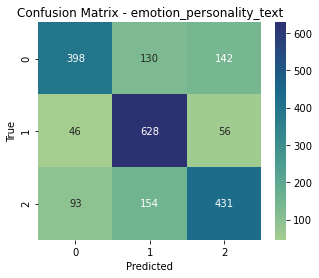

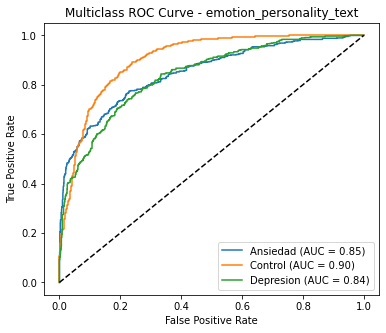

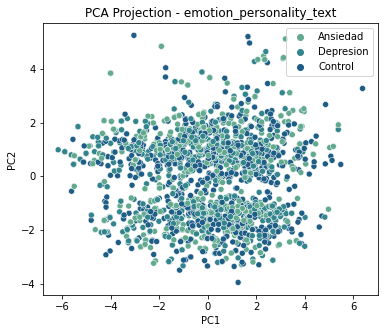

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.74      0.59      0.66       670
     Control       0.69      0.86      0.76       730
   Depresion       0.69      0.64      0.66       678

    accuracy                           0.70      2078
   macro avg       0.70      0.70      0.69      2078
weighted avg       0.70      0.70      0.70      2078



In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: emotion + personality + text features
emotion_personality_text = [
    "angry_facial", "disgust_facial", "fear_facial", "happy_facial", "sad_facial", "surprise_facial", "neutral_facial",
    "most_frequent_dominant_emotion", "average_face_confidence",
    "extraversion", "neuroticism", "agreeableness", "conscientiousness", "openness",
    "self_esteem", "stress_high", "stress_medium", "stress_low", 
    "depression_high", "depression_medium", "depression_low",
    "tfidf_depression", "tfidf_anxiety", "tfidf_just", "tfidf_feeling", "tfidf_help", "tfidf_life",
    "tfidf_people", "tfidf_talk", "tfidf_like", "tfidf_going"
]

# Select features and target
X_s = X_text_augmented[emotion_personality_text].copy()
y_s = y.copy()

# One-hot encode 'most_frequent_dominant_emotion'
X_s = pd.get_dummies(X_s, columns=["most_frequent_dominant_emotion"], drop_first=True)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - emotion_personality_text")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - emotion_personality_text")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - emotion_personality_text")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


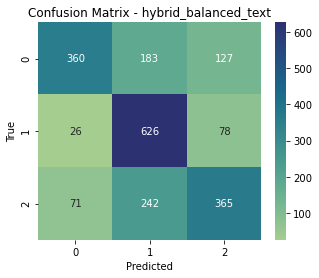

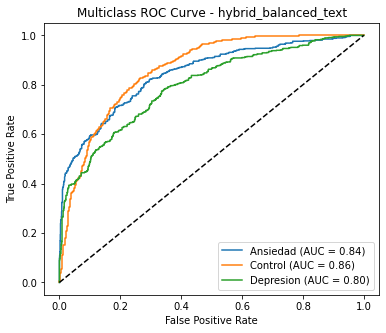

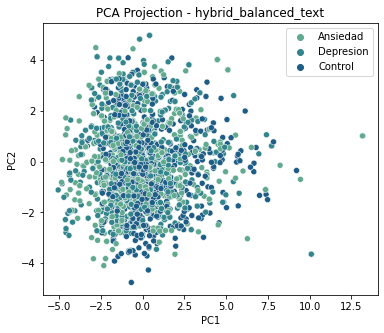

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.79      0.54      0.64       670
     Control       0.60      0.86      0.70       730
   Depresion       0.64      0.54      0.58       678

    accuracy                           0.65      2078
   macro avg       0.67      0.64      0.64      2078
weighted avg       0.67      0.65      0.64      2078



In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: Balanced from facial + voice + text + personality + stress/helplessness
hybrid_balanced_text = [
    "happy_facial", "sad_facial", "neutral_facial",
    "voice_mean", "voice_sd", "voice_median", "voice_mode", "voice_Q25", "voice_Q75", "voice_IQR",
    "self_esteem", "neuroticism", "conscientiousness", "openness",
    "stress_high", "helplessness_low", "self_efficacy_high",
    "tfidf_depression", "tfidf_anxiety", "tfidf_felt", "tfidf_life", "tfidf_people", "tfidf_good"
]

# Select and prepare data
X_s = X_text_augmented[hybrid_balanced_text].copy()
y_s = y.copy()

# Ensure all features are numeric
X_s = pd.get_dummies(X_s, drop_first=True)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - hybrid_balanced_text")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - hybrid_balanced_text")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - hybrid_balanced_text")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


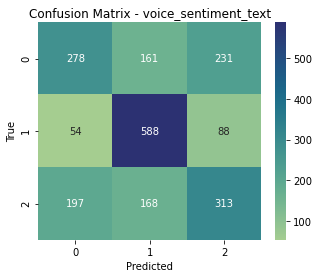

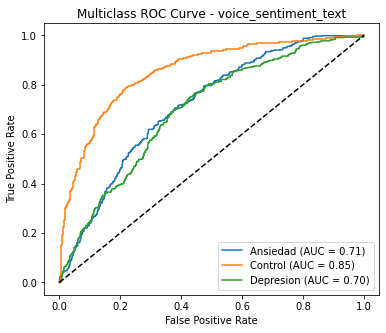

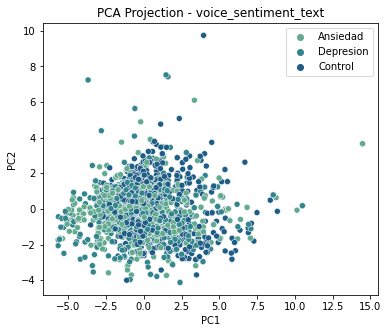

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.53      0.41      0.46       670
     Control       0.64      0.81      0.71       730
   Depresion       0.50      0.46      0.48       678

    accuracy                           0.57      2078
   macro avg       0.55      0.56      0.55      2078
weighted avg       0.56      0.57      0.56      2078



In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: voice features + sentiment + text
voice_sentiment_text = [
    "voice_mean", "voice_sd", "voice_median", "voice_mode", "voice_Q25", "voice_Q75", "voice_IQR",
    "voice_skewness", "voice_kurtosis", "voice_rmse", "pitch", "tone",
    "sentiment_polarity", "sentiment_subjectivity",
    "tfidf_feel", "tfidf_feeling", "tfidf_like", "tfidf_make", "tfidf_want", "tfidf_talk", "tfidf_think"
]

# Select and prepare data
X_s = X_text_augmented[voice_sentiment_text].copy()
y_s = y.copy()

# Ensure all features are numeric
X_s = pd.get_dummies(X_s, drop_first=True)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - voice_sentiment_text")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - voice_sentiment_text")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - voice_sentiment_text")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


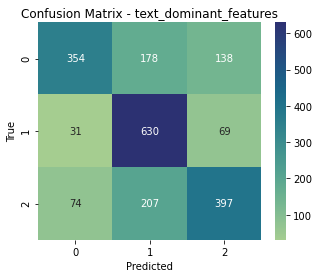

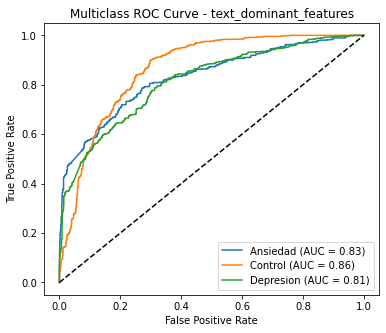

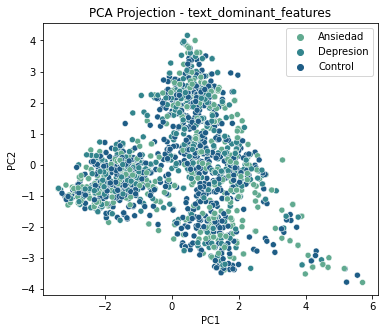

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.77      0.53      0.63       670
     Control       0.62      0.86      0.72       730
   Depresion       0.66      0.59      0.62       678

    accuracy                           0.66      2078
   macro avg       0.68      0.66      0.66      2078
weighted avg       0.68      0.66      0.66      2078



In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: text and dominant emotional/facial indicators
text_dominant_features = [
    "most_frequent_dominant_emotion", "angry_facial", "happy_facial", "sad_facial", "disgust_facial",
    "fear_facial", "neutral_facial", "surprise_facial", "sentiment_polarity", "sentiment_subjectivity",
    "tfidf_anxiety", "tfidf_bad", "tfidf_depression", "tfidf_didn", "tfidf_don", "tfidf_felt",
    "tfidf_just", "tfidf_life", "tfidf_love", "tfidf_people", "tfidf_said", "tfidf_tell", "tfidf_think"
]

# Select and prepare data
X_s = X_text_augmented[text_dominant_features].copy()
y_s = y.copy()

# One-hot encode categorical if needed
X_s = pd.get_dummies(X_s, drop_first=True)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - text_dominant_features")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - text_dominant_features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - text_dominant_features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


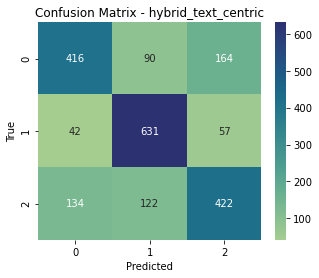

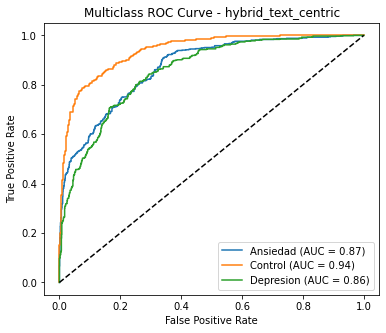

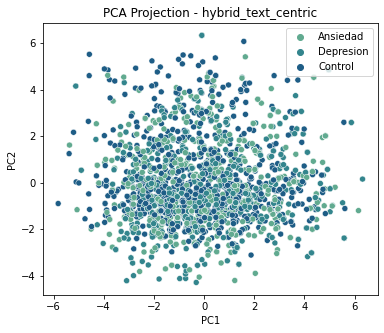

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.70      0.62      0.66       670
     Control       0.75      0.86      0.80       730
   Depresion       0.66      0.62      0.64       678

    accuracy                           0.71      2078
   macro avg       0.70      0.70      0.70      2078
weighted avg       0.70      0.71      0.70      2078



In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Subgroup: Text-centric hybrid (TF-IDF + facial/emotion/psychological/speech)
hybrid_text_centric = [
    # Core facial/emotional indicators
    "happy_facial", "sad_facial", "neutral_facial", "angry_facial", "disgust_facial", "fear_facial",
    "most_frequent_dominant_emotion", "average_face_confidence",

    # Psychological traits
    "extraversion", "neuroticism", "agreeableness", "conscientiousness", "openness",
    "self_esteem", "stress_high", "helplessness_high", "self_efficacy_low",

    # Voice + audio emotion
    "voice_mean", "voice_sd", "voice_skewness", "pitch", "tone", "sad_voice", "happy_voice", "calm_voice",

    # Textual sentiment & tense indicators
    "sentiment_polarity", "sentiment_subjectivity", "tense_present", "tense_past",

    # TF-IDF top 16 markers
    "tfidf_anxiety", "tfidf_bad", "tfidf_body", "tfidf_day", "tfidf_depression", "tfidf_did",
    "tfidf_doing", "tfidf_feel", "tfidf_feeling", "tfidf_felt", "tfidf_life", "tfidf_love",
    "tfidf_people", "tfidf_said", "tfidf_tell", "tfidf_think"
]

# Select and prepare data
X_s = X_text_augmented[hybrid_text_centric].copy()
y_s = y.copy()

# One-hot encode categorical if needed
X_s = pd.get_dummies(X_s, drop_first=True)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - hybrid_text_centric")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - hybrid_text_centric")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - hybrid_text_centric")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


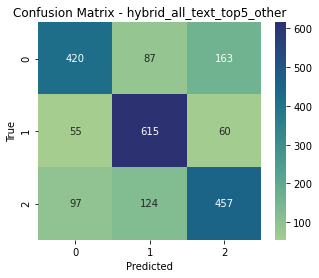

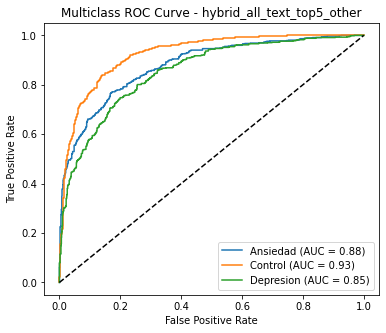

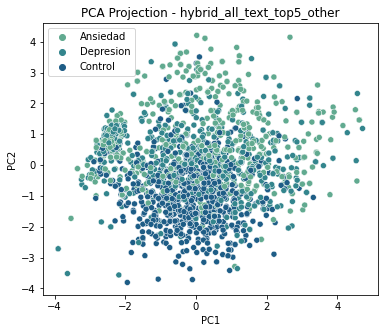

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.73      0.63      0.68       670
     Control       0.74      0.84      0.79       730
   Depresion       0.67      0.67      0.67       678

    accuracy                           0.72      2078
   macro avg       0.72      0.71      0.71      2078
weighted avg       0.72      0.72      0.72      2078



In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define all TF-IDF columns (ensure order matches your dataset)
tfidf_cols_all = [col for col in X_text_augmented.columns if col.startswith("tfidf_")]

# Manually select 5 top non-text features (based on previous models or domain knowledge)
top5_non_text = [
    "happy_facial",          # high emotional facial expressiveness
    "neuroticism",           # strong psychological predictor
    "pitch",                 # related to vocal expressiveness
    "stress_high",           # frequent mental state indicator
    "sentiment_polarity"     # textual sentiment metadata
]

# Final hybrid group: all TF-IDF + 5 best other features
hybrid_all_text_top5_other = tfidf_cols_all + top5_non_text

# Select data
X_s = X_text_augmented[hybrid_all_text_top5_other].copy()
y_s = y.copy()

# Encode categorical if any
X_s = pd.get_dummies(X_s, drop_first=True)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_s.loc[X_train.index])
X_test_s = scaler.transform(X_s.loc[X_test.index])
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train_s)
y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - hybrid_all_text_top5_other")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve - hybrid_all_text_top5_other")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_s)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - hybrid_all_text_top5_other")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))


In [85]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Build hybrid dataset: text + top mixed features
tfidf_cols = [col for col in X_text_augmented.columns if col.startswith("tfidf_")]
non_text_top = [
    "happy_facial", "neuroticism", "stress_high", "sentiment_polarity",
    "voice_mean", "voice_sd", "openness", "sad_facial", "fear_facial", "pitch",
    "calm_voice", "angry_voice", "tense_past", "self_esteem", "imagination",
    "surprised_voice", "compassion", "language", "depression_high", "voice_Q75"
]
hybrid_optimized_all = tfidf_cols + non_text_top

# Subset and encode
X_s = X_text_augmented[hybrid_optimized_all].copy()
y_s = y.copy()
X_s = pd.get_dummies(X_s, drop_first=True)

# Train/Test split (already done before)
X_train_s = X_s.loc[X_train.index]
X_test_s = X_s.loc[X_test.index]
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]


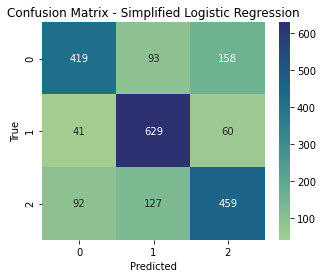

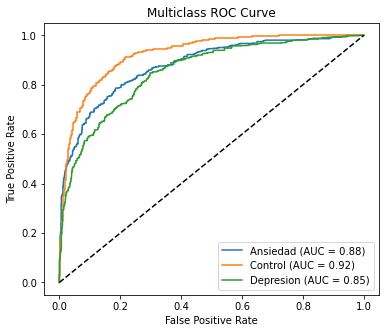

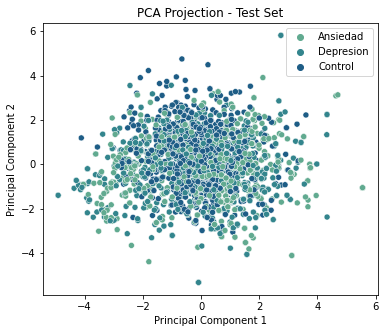

📊 Classification Report:

              precision    recall  f1-score   support

    Ansiedad       0.76      0.63      0.69       670
     Control       0.74      0.86      0.80       730
   Depresion       0.68      0.68      0.68       678

    accuracy                           0.73      2078
   macro avg       0.73      0.72      0.72      2078
weighted avg       0.73      0.73      0.72      2078



In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Rebuild the optimized hybrid feature list
tfidf_cols = [col for col in X_text_augmented.columns if col.startswith("tfidf_")]
non_text_top = [
    "happy_facial", "neuroticism", "stress_high", "sentiment_polarity",
    "voice_mean", "voice_sd", "openness", "sad_facial", "fear_facial", "pitch"
]
hybrid_simple = tfidf_cols + non_text_top

# Select and preprocess data
X_s = X_text_augmented[hybrid_simple].copy()
X_s = pd.get_dummies(X_s, drop_first=True)
X_train_s = X_s.loc[X_train.index]
X_test_s = X_s.loc[X_test.index]
y_train_s = y.loc[X_train.index]
y_test_s = y.loc[X_test.index]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test_s)

# Train simple multiclass logistic regression
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train_scaled, y_train_s)
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_s, y_pred), annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix - Simplified Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Multiclass ROC Curve
plt.figure(figsize=(6, 5))
for i, label in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve((y_test_s == label).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test_s, palette="crest")
plt.title("PCA Projection - Test Set")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Report
print("📊 Classification Report:\n")
print(classification_report(y_test_s, y_pred))
